# Import Packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
%matplotlib inline

import gc

import torch
import hazm
from torch import nn
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchsummary import summary

from transformers import BertTokenizer
from transformers import BertModel

# Loading Data By Dataframe

In [2]:
dict_poets = {'Attar':'attar_norm.txt', 'Jami':'jami_norm.txt', 'Ferdowsi':'ferdousi_norm.txt',
             'Khwaju':'khajoo_norm.txt', 'Rumi':'moulavi_norm.txt', 'ShahNimatullah':'shahnematollah_norm.txt',
             'Farrokhi':'farrokhi_norm.txt', 'Bahar':'bahar_norm.txt', 'Asadi':'asadi_norm.txt','Vahshi':'vahshi_norm.txt'}

poet_labels = {'Attar':0, 'Jami':1, 'Ferdowsi':2, 'Khwaju':3, 'Rumi':4, 
                            'ShahNimatullah':5, 'Farrokhi':6, 'Bahar':7, 'Asadi':8,'Vahshi':9} 

df_poets = pd.DataFrame(dict_poets.items(), columns=['PoetsName', 'PoetsFile'])

df_beyt_init = pd.DataFrame(columns=['Beyts', 'Poet'])

for i in range(len(dict_poets.items())):
    df_idx = pd.read_csv('./normalized/'+df_poets['PoetsFile'][i], header = None)

    beyt_list = []
    
    print('Beyt Number In '+df_poets['PoetsName'][i]+ ' File Is: ', int(len(df_idx)/2))

    for j in range(int(len(df_idx)/2)):
        beyt_list.append(df_idx.iloc[2*j]+' / '+ df_idx.iloc[2*j+1])
        
    df_beyt = pd.DataFrame(beyt_list)

    df_beyt["Beyts"] = df_poets['PoetsName'][i]
    df_beyt.columns = ['Beyts', 'Poet']
    df_beyt_init = pd.concat([df_beyt_init, df_beyt], ignore_index=True, sort=False)


df_beyt_init = df_beyt_init.sample(frac=1).reset_index(drop=True)

df_beyt_init

Beyt Number In Attar File Is:  95219
Beyt Number In Jami File Is:  33096
Beyt Number In Ferdowsi File Is:  49608
Beyt Number In Khwaju File Is:  8846
Beyt Number In Rumi File Is:  26478
Beyt Number In ShahNimatullah File Is:  14957
Beyt Number In Farrokhi File Is:  11985
Beyt Number In Bahar File Is:  20766
Beyt Number In Asadi File Is:  8807
Beyt Number In Vahshi File Is:  10494


,Beyts,Poet
0,در طلبم رنج سفر برده ای / زین سفرم تحفه چه آور...,Jami
1,در خرابات مغان مست و خراب / عزم رندی کرده ام آ...,ShahNimatullah
2,گفتم که مگر کلی وصل تو بدانستم / صد جان و دل خ...,Attar
3,روی در کرسی و عرش آوردند / ساختند از سر کرسی پایه,Jami
4,بدو گفت رستم که گیهان تراست / همه کهترانیم و ف...,Ferdowsi
...,...,...
280251,جانش از تیرگی جهل رهید / اگر آن علم او یقین بودی,Jami
280252,که کمر بستن تو کرد مرا خسته جگر / چه کمر بندی ...,Farrokhi
280253,در هوای آنک گویندت زهی / بسته ای در گردن جانت زهی,Rumi
280254,همه اندر یکی در عین منزل / حقیقت در یقین هستند...,Attar


# Load Bert Tokenizer & Create Dataset Class

In [3]:
tokenizer = BertTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

class PoetsDataset(torch.utils.data.Dataset):
        
    def __init__(self, df, labels):

        self.labels = [labels[label] for label in df['Poet']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 32, truncation=True,
                                return_tensors="pt") for text in df['Beyts']]
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

# Load Dataset Iterable

In [4]:
# Split Dataset By (80,10,10) For (Train, Test, Validation)
train_data, val_data, test_data = np.split(df_beyt_init.sample(frac=1, random_state=42), [int(.8*len(df_beyt_init)), int(.9*len(df_beyt_init))])

train_dataset = PoetsDataset(train_data, poet_labels)
val_dataset = PoetsDataset(val_data, poet_labels)
test_dataset = PoetsDataset(test_data, poet_labels) 

print('Number Of Training Set : ',len(train_data))
print('Number Of Validation Set : ',len(val_data))
print('Number Of Test Set : ',len(test_data))

Number Of Training Set :  224204
Number Of Validation Set :  28026
Number Of Test Set :  28026


# Make Dataset Iterable

In [5]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                          batch_size=batch_size*2, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size*2, 
                                          shuffle=False)

# (A) : Load Frized BERT Model & Create Class Model

In [32]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        
        for param in self.bert.parameters():
            param.requires_grad = False
        
        self.linear = nn.Linear(768, 10)

    def forward(self, input_ids, attention_mask):

        _, out_cls = self.bert(input_ids= input_ids, attention_mask=attention_mask,return_dict=False)
        out = self.linear(out_cls)

        return out

In [33]:
model_bert = BertClassifier()

trainable_param_number = sum(p.numel() for p in model_bert.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

gc.collect()
torch.cuda.empty_cache()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable Param Number Is : 7,690


# (A) : Define Hyper Parameters & Optimizer & Loss Function

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_bert = model_bert.to(device)

criterion = nn.CrossEntropyLoss()

epochs = 5
lr_adam = 4e-4
optimizer_adam = torch.optim.Adam(model_bert.parameters(), lr=lr_adam)

# (A) : Define Train & Validation Loop For Frized Bert Model

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
                
        attention_mask = X['attention_mask'].to(device)
        input_ids = X['input_ids'].squeeze(1).to(device)
        
        pred = model(input_ids, attention_mask)
        
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")
    
def val_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, val_acc, val_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            
            attention_mask = X['attention_mask'].to(device)
            input_ids = X['input_ids'].squeeze(1).to(device)
            
            pred = model(input_ids, attention_mask)
            
            loss = loss_fn(pred, y.to(device))
            
            val_loss += loss.item()
            val_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    val_loss /= num_batches
    val_acc /= size
    
    log['val_loss'].append(val_loss)
    log['val_acc'].append(val_acc)
    
    print(f"Validation Result: \n Accuracy: {(100*val_acc):>0.1f}%, Avg Validation loss: {val_loss:>8f} \n")  

# (A) : Training Process Of Frized Bert Model

In [36]:
log = {'train_loss':[], 'val_loss' : [], 'train_acc' : [], 'val_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_bert.train()
    train_loop(train_loader, model_bert, criterion, optimizer_adam, log)
    model_bert.eval()
    val_loop(val_loader, model_bert, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 45.2%, Avg Train loss: 1.644558 

Validation Result: 
 Accuracy: 48.6%, Avg Validation loss: 1.533087 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 47.8%, Avg Train loss: 1.553489 

Validation Result: 
 Accuracy: 50.4%, Avg Validation loss: 1.464459 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 48.5%, Avg Train loss: 1.529910 

Validation Result: 
 Accuracy: 51.2%, Avg Validation loss: 1.455282 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 48.9%, Avg Train loss: 1.514877 

Validation Result: 
 Accuracy: 52.0%, Avg Validation loss: 1.434990 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 49.2%, Avg Train loss: 1.505541 

Validation Result: 
 Accuracy: 52.1%, Avg Validation loss: 1.420549 

Done!


# (A) : Plot Result of Frized Bert Model

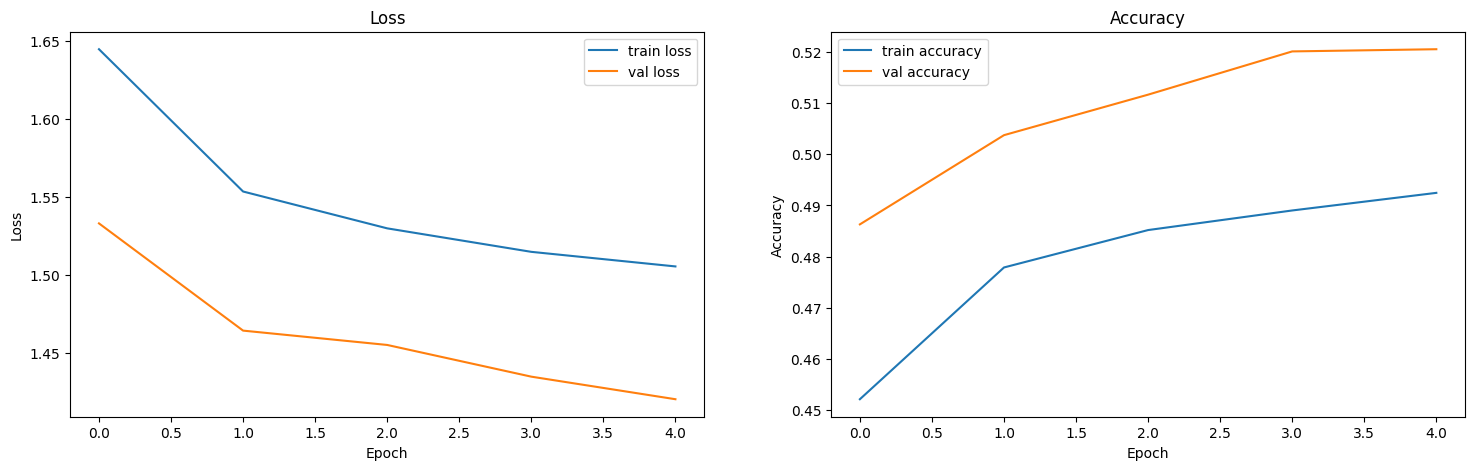

In [39]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss')
plt.legend(['train loss', 'val loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['val_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy')
plt.legend(['train accuracy', 'val accuracy'])

# (A) : Evaluate Frized Bert Model On Different Metrics

In [12]:
def EvaluateModel(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_acc = 0, 0
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():
        for X, y in dataloader:
            
            attention_mask = X['attention_mask'].to(device)
            input_ids = X['input_ids'].squeeze(1).to(device)
            
            pred = model(input_ids, attention_mask)
            
            loss = loss_fn(pred, y.to(device))
            
            y_pred_list.extend(pred.argmax(1).cpu().numpy())
            y_true_list.extend(y.numpy())
            
            test_loss += loss.item()
            
    test_loss /= num_batches
    
    return y_pred_list, y_true_list, test_loss 

# (A) : Conclusion

Accuracy Test : 0.4876186398344394
Loss Test : 1.5119087826715756
F1 Score Test : 0.4876186398344394
Trainable Param Number Is : 7,690


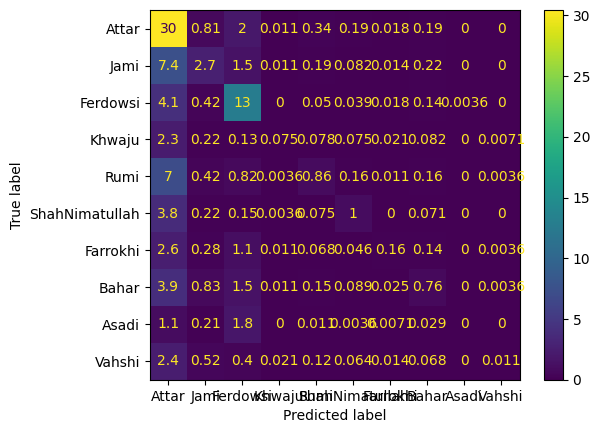

In [13]:
model_bert.eval()
y_pred, y_true, test_loss = EvaluateModel(test_loader, model_bert, criterion)

acc = accuracy_score(y_true, y_pred)
f1_score_micro = f1_score(y_true, y_pred, average='micro')
f1_score_macro = f1_score(y_true, y_pred, average='macro')

# print(classification_report(y_true, y_pred, target_names=target_names))
print(f'Accuracy Test : {accuracy_score(y_true, y_pred)}')
print(f'Loss Test : {test_loss}')
print(f'F1 Score Test : {f1_score_micro}')

classes = [i for i in poet_labels]
cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix/np.sum(cf_matrix) * 100, display_labels = [i for i in classes])
disp.plot()

trainable_param_number = sum(p.numel() for p in model_bert.parameters() if p.requires_grad)
print(f"Trainable Param Number Is : {trainable_param_number:,}")

# (B) : Load Pretrained BERT Model & Create Class Model (Adam)

In [14]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        self.linear = nn.Linear(768, 10)

    def forward(self, input_ids, attention_mask):

        _, out_cls = self.bert(input_ids= input_ids, attention_mask=attention_mask,return_dict=False)
        out = self.linear(out_cls)

        return out

In [15]:
model_bert_pretrained_adam = BertClassifier()

trainable_param_number = sum(p.numel() for p in model_bert_pretrained_adam.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

gc.collect()
torch.cuda.empty_cache()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable Param Number Is : 162,849,034


# (B) : Define Hyper Parameters & Optimizer & Loss Function (Adam)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_bert_pretrained_adam = model_bert_pretrained_adam.to(device)

criterion = nn.CrossEntropyLoss()

epochs = 4
lr_adam = 5e-5
optimizer_adam = torch.optim.Adam(model_bert_pretrained_adam.parameters(), lr=lr_adam)

# (B) : Define Train & Validation Loop For Pretrained Bert Model (Adam)

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
                
        attention_mask = X['attention_mask'].to(device)
        input_ids = X['input_ids'].squeeze(1).to(device)
        
        pred = model(input_ids, attention_mask)
        
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")
    
def val_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, val_acc, val_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            
            attention_mask = X['attention_mask'].to(device)
            input_ids = X['input_ids'].squeeze(1).to(device)
            
            pred = model(input_ids, attention_mask)
            
            loss = loss_fn(pred, y.to(device))
            
            val_loss += loss.item()
            val_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    val_loss /= num_batches
    val_acc /= size
    
    log['val_loss'].append(val_loss)
    log['val_acc'].append(val_acc)
    
    print(f"Validation Result: \n Accuracy: {(100*val_acc):>0.1f}%, Avg Validation loss: {val_loss:>8f} \n")  

# (B) : Training Process Of Pretrained Bert Model (Adam)

In [18]:
log = {'train_loss':[], 'val_loss' : [], 'train_acc' : [], 'val_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_bert_pretrained_adam.train()
    train_loop(train_loader, model_bert_pretrained_adam, criterion, optimizer_adam, log)
    model_bert_pretrained_adam.eval()
    val_loop(val_loader, model_bert_pretrained_adam, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 72.4%, Avg Train loss: 0.813219 

Validation Result: 
 Accuracy: 78.3%, Avg Validation loss: 0.632322 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 83.5%, Avg Train loss: 0.484034 

Validation Result: 
 Accuracy: 81.6%, Avg Validation loss: 0.548416 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 88.6%, Avg Train loss: 0.334565 

Validation Result: 
 Accuracy: 82.6%, Avg Validation loss: 0.539169 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 91.9%, Avg Train loss: 0.238870 

Validation Result: 
 Accuracy: 82.3%, Avg Validation loss: 0.589404 

Done!


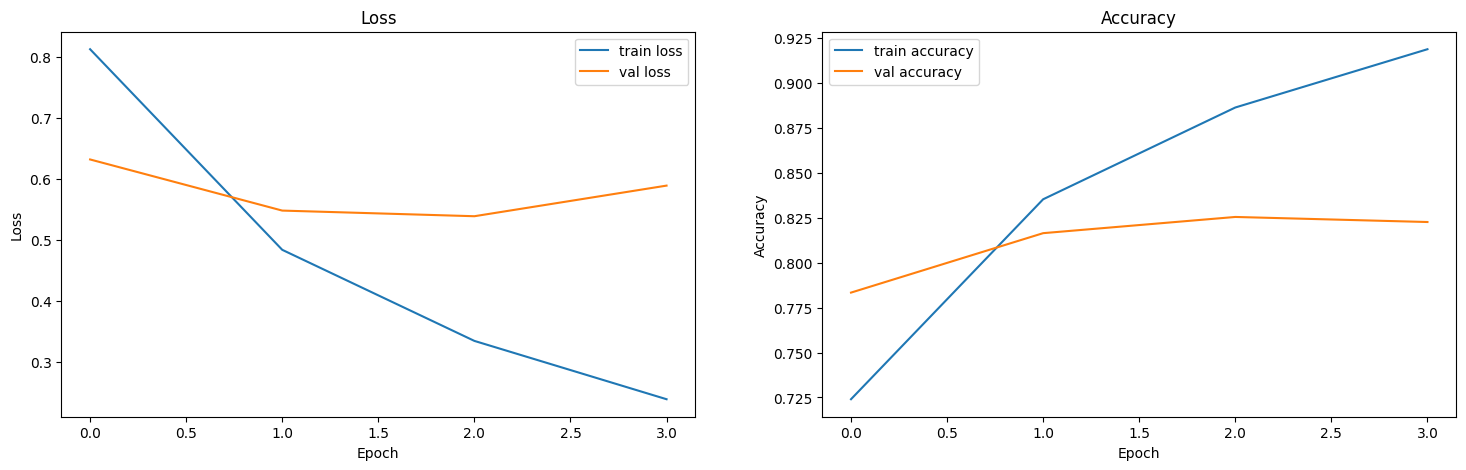

In [19]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss')
plt.legend(['train loss', 'val loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['val_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy')
plt.legend(['train accuracy', 'val accuracy'])

# (B) : Evaluate Pretrained Bert Model On Different Metrics (Adam)

In [20]:
def EvaluateModel(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_acc = 0, 0
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():
        for X, y in dataloader:
            
            attention_mask = X['attention_mask'].to(device)
            input_ids = X['input_ids'].squeeze(1).to(device)
            
            pred = model(input_ids, attention_mask)
            
            loss = loss_fn(pred, y.to(device))
            
            y_pred_list.extend(pred.argmax(1).cpu().numpy())
            y_true_list.extend(y.numpy())
            
            test_loss += loss.item()
            
    test_loss /= num_batches
    
    return y_pred_list, y_true_list, test_loss 

# (B) : Conclusion (Adam)

Accuracy Test : 0.8274102618996646
Loss Test : 0.5629528131182879
F1 Score Test : 0.8274102618996646
Trainable Param Number Is : 162,849,034


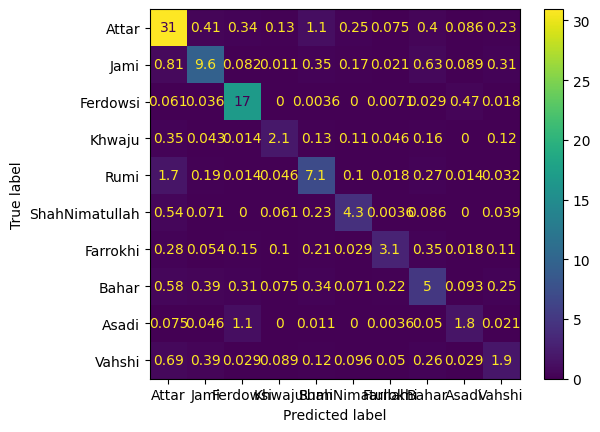

In [21]:
model_bert_pretrained_adam.eval()
y_pred, y_true, test_loss = EvaluateModel(test_loader, model_bert_pretrained_adam, criterion)

acc = accuracy_score(y_true, y_pred)
f1_score_micro = f1_score(y_true, y_pred, average='micro')
f1_score_macro = f1_score(y_true, y_pred, average='macro')

# print(classification_report(y_true, y_pred, target_names=target_names))
print(f'Accuracy Test : {accuracy_score(y_true, y_pred)}')
print(f'Loss Test : {test_loss}')
print(f'F1 Score Test : {f1_score_micro}')

classes = [i for i in poet_labels]
cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix/np.sum(cf_matrix) * 100, display_labels = [i for i in classes])
disp.plot()

trainable_param_number = sum(p.numel() for p in model_bert_pretrained_adam.parameters() if p.requires_grad)
print(f"Trainable Param Number Is : {trainable_param_number:,}")

# (B) : Load Pretrained BERT Model & Create Class Model (SGD)

In [40]:
class BertClassifier(nn.Module):

    def __init__(self):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        self.linear = nn.Linear(768, 10)

    def forward(self, input_ids, attention_mask):

        _, out_cls = self.bert(input_ids= input_ids, attention_mask=attention_mask,return_dict=False)
        out = self.linear(out_cls)

        return out

In [41]:
model_bert_pretrained_sgd = BertClassifier()

trainable_param_number = sum(p.numel() for p in model_bert_pretrained_sgd.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

gc.collect()
torch.cuda.empty_cache()

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainable Param Number Is : 162,849,034


# (B) : Define Hyper Parameters & Optimizer & Loss Function (SGD)

In [42]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_bert_pretrained_sgd = model_bert_pretrained_sgd.to(device)

criterion = nn.CrossEntropyLoss()

epochs = 4
lr_sgd = 5e-5
optimizer_sgd= torch.optim.SGD(model_bert_pretrained_sgd.parameters(), lr=lr_sgd, momentum=0.9)

# (B) : Define Train & Validation Loop For Pretrained Bert Model (SGD)

In [43]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
                
        attention_mask = X['attention_mask'].to(device)
        input_ids = X['input_ids'].squeeze(1).to(device)
        
        pred = model(input_ids, attention_mask)
        
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")
    
def val_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, val_acc, val_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            
            attention_mask = X['attention_mask'].to(device)
            input_ids = X['input_ids'].squeeze(1).to(device)
            
            pred = model(input_ids, attention_mask)
            
            loss = loss_fn(pred, y.to(device))
            
            val_loss += loss.item()
            val_acc += (pred.argmax(1) == y.to(device)).type(torch.float).sum().item()

    val_loss /= num_batches
    val_acc /= size
    
    log['val_loss'].append(val_loss)
    log['val_acc'].append(val_acc)
    
    print(f"Validation Result: \n Accuracy: {(100*val_acc):>0.1f}%, Avg Validation loss: {val_loss:>8f} \n")  

# (B) : Training Process Of Pretrained Bert Model (SGD)

In [44]:
log = {'train_loss':[], 'val_loss' : [], 'train_acc' : [], 'val_acc' : []}
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model_bert_pretrained_sgd.train()
    train_loop(train_loader, model_bert_pretrained_sgd, criterion, optimizer_sgd, log)
    model_bert_pretrained_sgd.eval()
    val_loop(val_loader, model_bert_pretrained_sgd, criterion, log)
print("Done!")

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 49.6%, Avg Train loss: 1.515480 

Validation Result: 
 Accuracy: 59.7%, Avg Validation loss: 1.197512 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 61.4%, Avg Train loss: 1.142830 

Validation Result: 
 Accuracy: 65.7%, Avg Validation loss: 1.016332 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 65.8%, Avg Train loss: 1.004832 

Validation Result: 
 Accuracy: 69.0%, Avg Validation loss: 0.908912 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 68.7%, Avg Train loss: 0.918386 

Validation Result: 
 Accuracy: 71.2%, Avg Validation loss: 0.843232 

Done!


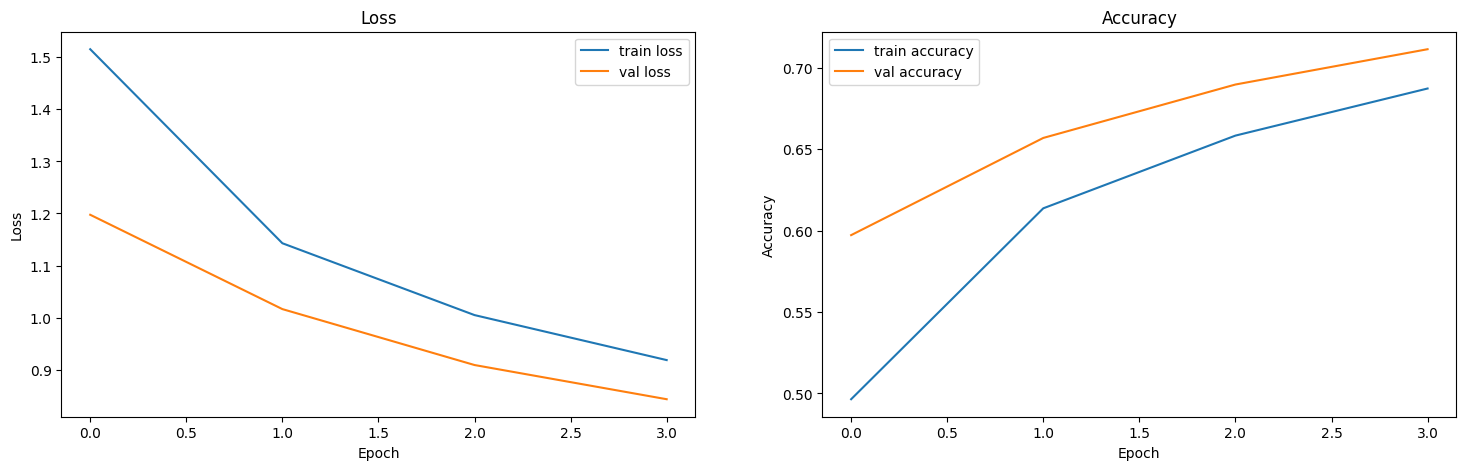

In [45]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss')
plt.legend(['train loss', 'val loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['val_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy')
plt.legend(['train accuracy', 'val accuracy'])

# (B) : Evaluate Pretrained Bert Model On Different Metrics (SGD)

In [28]:
def EvaluateModel(dataloader, model, loss_fn):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_acc = 0, 0
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():
        for X, y in dataloader:
            
            attention_mask = X['attention_mask'].to(device)
            input_ids = X['input_ids'].squeeze(1).to(device)
            
            pred = model(input_ids, attention_mask)
            
            loss = loss_fn(pred, y.to(device))
            
            y_pred_list.extend(pred.argmax(1).cpu().numpy())
            y_true_list.extend(y.numpy())
            
            test_loss += loss.item()
            
    test_loss /= num_batches
    
    return y_pred_list, y_true_list, test_loss 

# (B) : Conclusion (SGD)

Accuracy Test : 0.5166274173981303
Loss Test : 1.4368958639227636
F1 Score Test : 0.5166274173981303
Trainable Param Number Is : 162,849,034


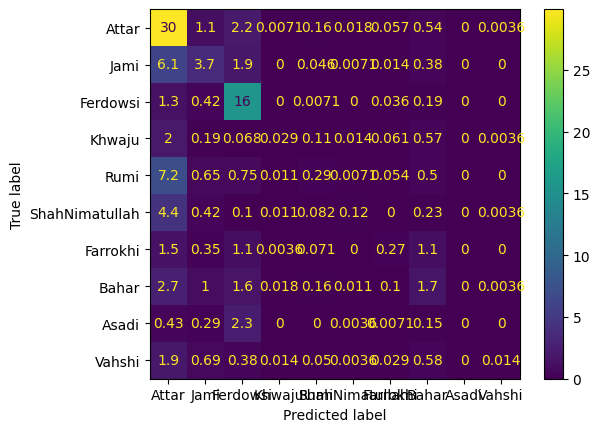

In [29]:
model_bert_pretrained_sgd.eval()
y_pred, y_true, test_loss = EvaluateModel(test_loader, model_bert_pretrained_sgd, criterion)

acc = accuracy_score(y_true, y_pred)
f1_score_micro = f1_score(y_true, y_pred, average='micro')
f1_score_macro = f1_score(y_true, y_pred, average='macro')

# print(classification_report(y_true, y_pred, target_names=target_names))
print(f'Accuracy Test : {accuracy_score(y_true, y_pred)}')
print(f'Loss Test : {test_loss}')
print(f'F1 Score Test : {f1_score_micro}')

classes = [i for i in poet_labels]
cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix/np.sum(cf_matrix) * 100, display_labels = [i for i in classes])
disp.plot()

trainable_param_number = sum(p.numel() for p in model_bert_pretrained_sgd.parameters() if p.requires_grad)
print(f"Trainable Param Number Is : {trainable_param_number:,}")

# (B) Comparing Adam & SGD:
Adam optimizer works better than SGD on pretrained BERT

# (C) Perplexity Of Two Models

In [38]:
def Perplexity(dataloader, model_frized, model_pretrained, loss_fn, num = 100):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss_frized = 0 
    test_loss_pretrained = 0
    test_sample = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            
            attention_mask = X['attention_mask'].to(device)
            input_ids = X['input_ids'].squeeze(1).to(device)
            
            pred_frized = model_frized(input_ids, attention_mask)
            pred_pretrained = model_pretrained(input_ids, attention_mask)

            
            loss_frized = loss_fn(pred_frized, y.to(device))
            loss_pretrained = loss_fn(pred_pretrained, y.to(device))

            
            test_loss_frized += loss_frized*len(y)
            test_loss_pretrained += loss_pretrained*len(y)
            
            test_sample += len(y) 
            if(test_sample >num):
                break
            
    test_loss_frized /= test_sample
    test_loss_pretrained /= test_sample

    
    perplexity_frized  = torch.exp(test_loss_frized)
    perplexity_pretrained  = torch.exp(test_loss_pretrained)
    
    return perplexity_frized, perplexity_pretrained

In [31]:
perplexity_frized, perplexity_pretrained = Perplexity(test_loader, model_bert, model_bert_pretrained_adam, criterion, num = 1000)

print('Perplexity Before Fine-tuning is : ', perplexity_frized.cpu().numpy())
print('Perplexity After  Fine-tuning is : ', perplexity_pretrained.cpu().numpy())

Perplexity Before Fine-tuning is :  4.3632994
Perplexity After  Fine-tuning is :  1.6912055


# Conclusion 

Perplexity Before Finetuning is more than after